In [1]:
import sionna.rt
import xarray as xr
import time
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import drjit as dr
import mitsuba as mi
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
import yaml
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies, AntennaPattern

from typing import Callable, List, Tuple


print("Sionna version:", sionna.rt.__version__)
print("tf version:", tf.__version__)

2025-12-15 06:43:40.931792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765781020.985620   62625 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765781021.002382   62625 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765781021.044373   62625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781021.044411   62625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765781021.044415   62625 computation_placer.cc:177] computation placer alr

Sionna version: 1.0.2
tf version: 2.19.0


In [2]:
scene = load_scene(r"/home/user/6GTandem_RT_server/6G_Tandem_kantoorruimte_v10/office_space.xml") 

2025-12-15 06:43:46 WARN wrk5 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

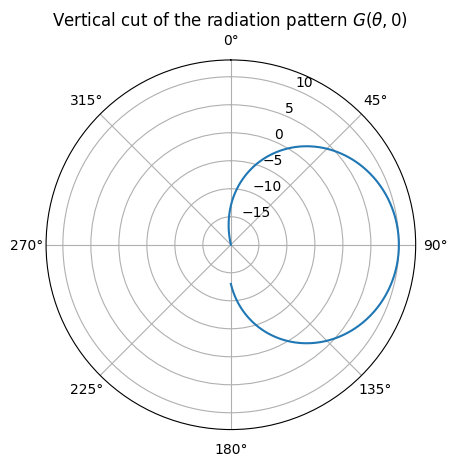

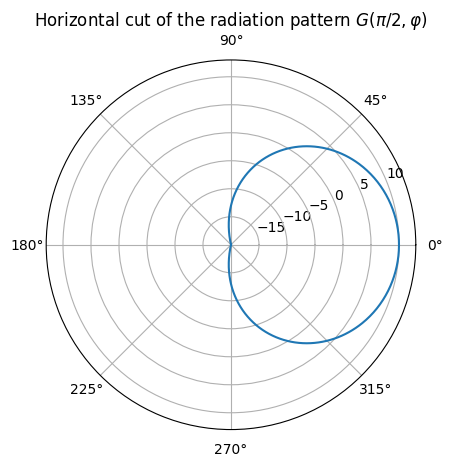

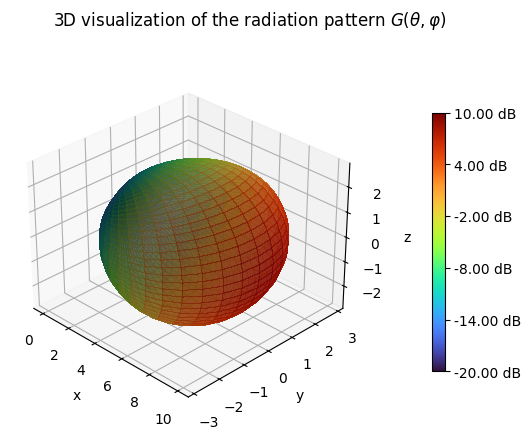

In [33]:
# --- Custom Pattern Function using Dr.Jit/Mitsuba ---
def v_cos_pattern(theta: mi.Float, phi: mi.Float) -> mi.Complex2f:
    r"""
    Vertically polarized measured antenna pattern using closest point.
    """

    # # builtin dipole
    # k = dr.sqrt(1.5)
    # c_theta = dr.abs(k*dr.sin(theta))

    # return mi.Complex2f(c_theta, 0)


    # builtin v_tr38901_pattern
    # Wrap phi to [-PI,PI]
    phi = phi+dr.pi
    phi -= dr.floor(phi/(2.*dr.pi))*2.*dr.pi
    phi -= dr.pi

    # Zenith pattern
    theta_3db = phi_3db = 65./180.*dr.pi
    a_max = sla_v = 30.
    g_e_max = 10.
    a_v = -dr.min([12.*((theta-dr.pi/2.)/theta_3db)**2, sla_v])
    a_h = -dr.min([12.*(phi/phi_3db)**2, a_max])
    a_db = -dr.min([-(a_v + a_h), a_max]) + g_e_max
    a = dr.power(10., a_db/10.)
    c_theta = dr.sqrt(a)

    return mi.Complex2f(c_theta, 0)

    # Register all available antenna patterns
def create_factory(name: str) -> Callable[[str, str], sionna.rt.antenna_pattern.PolarizedAntennaPattern]:
    r"""Create a factory method for the instantiation of polarized antenna
    patterns

    Note that there must be a vertical antenna pattern function with name
    "v_{s}_pattern" which is used.

    :param name: Name under which to register the factory method
    :returns: Callable creating an instance of PolarizedAntennaPattern
    """
    def f(*, polarization, polarization_model="tr38901_2"):
        return sionna.rt.antenna_pattern.PolarizedAntennaPattern(
                                v_pattern=globals()["v_" + name + "_pattern"],
                                polarization=polarization,
                                polarization_model=polarization_model)
    return f

for s in ["cos"]:
    sionna.rt.antenna_pattern.register_antenna_pattern(s, create_factory(s))



# create antenna array based and plot antenna pattern
scene.tx_array = PlanarArray(num_rows=1,#config['antenna_config']['N_antenna_rows'],
                                num_cols=1,#config['antenna_config']['N_antenna_cols'],
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="cos",
                                polarization='V')
                                #polarization=config['antenna_config']['polarization'])

scene.tx_array.antenna_pattern.show()

In [59]:
# Assuming 'dr' is numpy for this non-Mitsuba environment, 
# or use appropriate types if running in a DrJit/Mitsuba context.

# The correct 90-degree rotation matrix around the Y-axis (R_y(pi/2))
R_y_90 = np.array([
    [ 0.0, 0.0, 1.0],
    [ 0.0, 1.0, 0.0],
    [-1.0, 0.0, 0.0]
])

def sph_to_cart_sionna(theta, phi):
    """Sionna r_hat conversion: Maps (theta, phi) to (3, N) Cartesian vectors."""
    # Matches r_hat: x = sin(theta)cos(phi), y = sin(theta)sin(phi), z = cos(theta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Stacks into an (3, N) matrix
    return np.stack([x, y, z], axis=0)

def cart_to_sph_sionna(v):
    """Sionna theta_phi_from_unit_vec: Maps (3, N) vectors to (theta, phi) arrays (N,)."""
    x, y, z = v[0, :], v[1, :], v[2, :]
    
    # Calculate the norm for each vector (column) along axis 0
    r = np.linalg.norm(v, axis=0)
    
    # Zenith angle (theta): theta = arccos(z/r) -> ALWAYS IN [0, pi]
    z_over_r = np.clip(z / r, -1.0, 1.0)
    theta = np.arccos(z_over_r)
    
    # Azimuth angle (phi): phi = atan2(y, x) -> ALWAYS IN (-pi, pi]
    phi = np.arctan2(y, x)
    
    return theta, phi

def adjust_angles(theta, phi):
    """Converts, rotates 90 degrees about Y, and converts back."""
    v = sph_to_cart_sionna(theta, phi) 
    
    # Apply the rotation
    # R_y_90 (3, 3) @ v (3, N) -> v_rot (3, N)
    v_rot = R_y_90 @ v
    
    # Convert back using the confirmed Sionna inverse functions
    theta_r, phi_r = cart_to_sph_sionna(v_rot)
    
    return theta_r, phi_r

# --- Example Usage ---
N = 20
theta_in = np.linspace(-np.pi, np.pi, N)
phi_in = np.linspace(-np.pi, np.pi, N)

theta_r, phi_r = adjust_angles(theta_in, phi_in)

print("--- Sionna Rotation Results ---")
print(f"Input theta (first 5): {theta_in[:5].round(3)} ... {theta_in[-5:].round(3)}")
print(f"Input phi (first 5): {phi_in[:5].round(3)} ... {phi_in[-5:].round(3)}")
print(f"Adjusted theta (Zenith [0, pi]): {theta_r[:5].round(3)} ... {theta_r[-5:].round(3)}")
print(f"Adjusted phi (Azimuth [-pi, pi]): {phi_r[:5].round(3)} ... {phi_r[-5:].round(3)}")

--- Sionna Rotation Results ---
Input theta (first 5): [-3.142 -2.811 -2.48  -2.15  -1.819] ... [1.819 2.15  2.48  2.811 3.142]
Input phi (first 5): [-3.142 -2.811 -2.48  -2.15  -1.819] ... [1.819 2.15  2.48  2.811 3.142]
Adjusted theta (Zenith [0, pi]): [1.571 1.883 2.077 2.046 1.811] ... [1.331 1.095 1.065 1.259 1.571]
Adjusted phi (Azimuth [-pi, pi]): [3.142 3.031 2.696 2.233 1.826] ... [1.826 2.233 2.696 3.031 3.142]


# measured

In [ ]:
def sph_to_cart(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.array([x, y, z])

def rotation_matrix(angles):
    """
    Computes the rotation matrix from ZYX Euler angles.

    Parameters
    ----------
    angles : array-like of shape (3,)
        Rotation angles [alpha, beta, gamma] in radians.
        alpha : rotation about Z
        beta  : rotation about Y
        gamma : rotation about X

    Returns
    -------
    rot_mat : ndarray of shape (3, 3)
        Rotation matrix.
    """

    a, b, c = angles  # alpha, beta, gamma

    sin_a, cos_a = np.sin(a), np.cos(a)
    sin_b, cos_b = np.sin(b), np.cos(b)
    sin_c, cos_c = np.sin(c), np.cos(c)

    r_11 = cos_a * cos_b
    r_12 = cos_a * sin_b * sin_c - sin_a * cos_c
    r_13 = cos_a * sin_b * cos_c + sin_a * sin_c

    r_21 = sin_a * cos_b
    r_22 = sin_a * sin_b * sin_c + cos_a * cos_c
    r_23 = sin_a * sin_b * cos_c - cos_a * sin_c

    r_31 = -sin_b
    r_32 = cos_b * sin_c
    r_33 = cos_b * cos_c

    rot_mat = np.array([
        [r_11, r_12, r_13],
        [r_21, r_22, r_23],
        [r_31, r_32, r_33]
    ])

    return rot_mat


def cart_to_sph(v):
    # v is the (3, N) matrix, where N is the number of rays
    x, y, z = v[0, :], v[1, :], v[2, :]
    
    # FIX: Calculate the norm for each ray (column) along axis 0.
    r = np.linalg.norm(v, axis=0) # <--- THIS IS CRITICAL AND MUST BE IN YOUR CODE
    
    z_over_r = np.clip(z / r, -1.0, 1.0)
    theta = np.arccos(z_over_r)
    phi = np.arctan2(y, x)
    
    # We apply the phi wrap here for proper [0, 2pi] indexing
    phi = np.where(phi < 0, phi + 2 * np.pi, phi) 
    
    return theta, phi

def adjust_angles(theta, phi):
    v = sph_to_cart(theta, phi)
    rot_mat = rotation_matrix(np.array([0, -dr.pi/2, 0])) #rotate_z_to_x(v)
    v_rot = rot_mat @ v
    theta_r, phi_r = cart_to_sph(v_rot)

    return theta_r, phi_r


# sanity check
print(f'sanity check rot axis ([1, 0, 0] expected), got: {rotate_z_to_x(np.array([0, 0, 1]))}') # must give [1, 0, 0]


""" custom patterns for sionna based on measurements """
# antenna pattern based on measurements
class MeasuredPattern(AntennaPattern):
    """
    Custom antenna pattern based on CSV data.
    The CSV must contain columns:
    'Phi[deg]', 'Theta[deg]', 'mag(rERHCP)[mV]', 'ang_deg(rERHCP)[deg]'
    """

    def __init__(self, csv_path, normalize=True):
        super().__init__()

        # ---- Load CSV ----
        df = pd.read_csv(csv_path)
        phi_deg = df["Phi[deg]"].values # degrees
        theta_deg = df["Theta[deg]"].values # degrees
        mag = df["mag(rERHCP)[mV]"].values/1000  # convert mV to V
        print(f'max mag in MeasuredPattern: {np.max(mag)*1000} mV')
        ang_deg = df["ang_deg(rERHCP)[deg]"].values

        # ---- Convert to radians and complex field ----
        phi = np.deg2rad(phi_deg)
        theta = np.deg2rad(theta_deg)
        print(f'phi min/max: {np.min(phi)}/{np.max(phi)} rad')
        print(f'theta min/max: {np.min(theta)}/{np.max(theta)} rad')

        field = mag * np.exp(1j * np.deg2rad(ang_deg))
        
        field_power = np.abs(field)**2
        field_pwr_db = 10 * np.log10(field_power + 1e-12)  # add small offset to avoid log(0)
        print(f'max field power in MeasuredPattern: {np.max(field_pwr_db)} db')

        # Optional normalization (to make max field = 1)
        if normalize:
            field = field / np.max(np.abs(field))

        # ---- Build regular grids for interpolation ----
        # (assuming uniform or nearly-uniform sampling)
        phi_unique = np.sort(np.unique(phi)) #+ np.pi
        #print(f'phi unique : {phi_unique}')
        theta_unique = np.sort(np.unique(theta)) #+ np.pi
        #print(f'theta unique : {theta_unique}')

        # reshape to 2D grid [len(theta), len(phi)]
        n_theta = len(theta_unique)
        n_phi = len(phi_unique)

        field_grid = field.reshape(n_theta, n_phi)

        # Interpolator over (theta, phi)
        self._interp = RegularGridInterpolator(
            (theta_unique, phi_unique),
            field_grid,
            method='nearest',
            bounds_error=False,
            fill_value=1e-8
        )

    @property
    def patterns(self):
        def f(theta, phi):
            # Convert TF tensors to numpy arrays for interpolation
            theta_np = theta.numpy()
            phi_np = phi.numpy()

            # todo find proper rotation such that y axis is outgoing ray
            # # Apply a phi offset todo debug
            # phi_offset_rad = np.deg2rad(0)  # example: rotate 180°
            # phi_np = (phi_np + phi_offset_rad) % (2*np.pi)

            # theta_offset_rad = np.deg2rad(0)  # example: rotate 180°
            # theta_np = (theta_np + theta_offset_rad) % (2*np.pi)
            #theta_np = theta_np - np.pi/2  # shift to elevation from zenith

            # theta_np = theta_np - np.pi/2 # point pattern in x direction instead of z direction
            # theta_np = (theta_np + np.pi) % (2*np.pi) - np.pi  # wrap to [-pi, pi]

            #theta_np, phi_np = adjust_angles(theta_np, phi_np) 
            theta_np = theta_np  #+ np.pi % (2*np.pi)
            phi_np = phi_np #+ np.pi % (2*np.pi)

            theta_np, phi_np = adjust_angles(theta_np, phi_np) 

            # theta_np += np.pi
            # phi_np += np.pi

            # Stack and interpolate
            pts = np.stack([theta_np, phi_np], axis=-1)
            field_np = self._interp(pts) #todo instead of interpolate find closest match

            # Convert back to TF complex tensor
            field = tf.constant(field_np, dtype=tf.complex64)

            # Convert from circular (RHCP) to linear components
            E_theta = field / tf.constant(np.sqrt(2), tf.complex64)
            E_phi   = 1j * field / tf.constant(np.sqrt(2), tf.complex64)
            return (E_theta, E_phi)

        # Single polarization (RHCP)
        return [f]

# register all measured patterns
for i in range(1, 5):
    path = f'/home/user/6GTandem_RT_server/antenna_patterns/element{i}.csv'

    def measured_pattern_factory(csv_path=path, normalize=False):
        """Factory method that returns an instance of the antenna pattern"""
        return MeasuredPattern(csv_path=csv_path, normalize=normalize)

    # Register it under a custom name
    sionna.rt.register_antenna_pattern(f"custom_measured_element_{i}", measured_pattern_factory)




sanity check rot axis ([1, 0, 0] expected), got: [1 0 0]


max mag in MeasuredPattern: 13110.3 mV
phi min/max: -3.141592653589793/3.141592653589793 rad
theta min/max: -3.141592653589793/3.141592653589793 rad
max field power in MeasuredPattern: 22.352252593304197 db


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>)

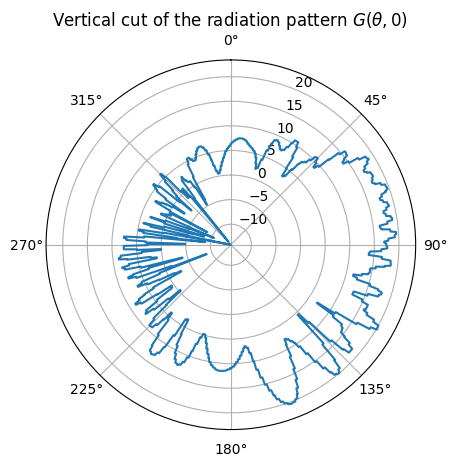

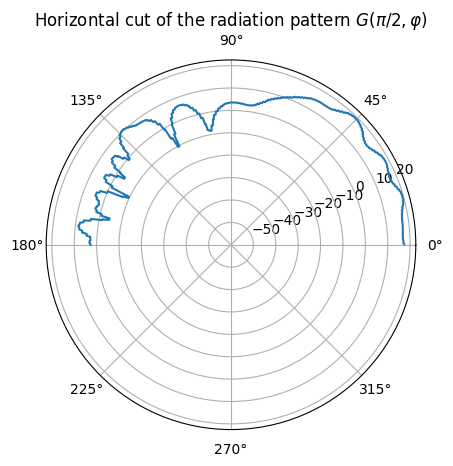

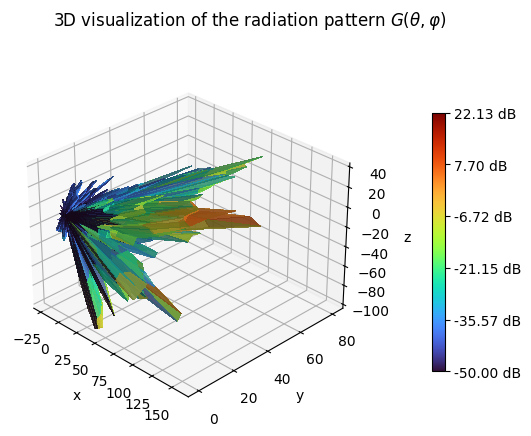

In [115]:
element_idx = 1 # select element
# create antenna array based and plot antenna pattern
scene.tx_array = PlanarArray(num_rows=1, #config['antenna_config']['N_antenna_rows'],
                                num_cols=1, #config['antenna_config']['N_antenna_cols'],
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=f"custom_measured_element_{element_idx}")
                                #polarization=config['antenna_confi

# check the pattern 
# phi_deg, theta_deg  = -180,-180
# phi = np.deg2rad(phi_deg)
# theta = np.deg2rad(theta_deg)
# E_theta, E_phi = scene.tx_array.antenna_pattern.patterns[0](tf.constant(theta), tf.constant(phi))
# gain = np.abs(E_theta)**2 + np.abs(E_phi)**2
# print(f'gain at (θ={theta_deg}°, φ={phi_deg}°): {gain}')
# print(f'magnitude at (θ={theta_deg}°, φ={phi_deg}°): {np.sqrt(gain)*1000} mV')
# gain_db = 10*np.log10(gain)
# print(f'gain in db: {gain_db}')
scene.tx_array.antenna_pattern.show()